# An XGBoost Forecasting example

The following example uses the "Revenue Passenger Miles for U.S. Air Carrier Domestic and International, Scheduled Passenger Flights" from the Federal Reserve Economic Data (FRED) database provided by the St. Louis Federal Reserve Bank. I selected this data because of the distinct seasonality and the deep impact of the COVID pandemic.

Citation: U.S. Bureau of Transportation Statistics, Revenue Passenger Miles for U.S. Air Carrier Domestic and International, Scheduled Passenger Flights [RPM], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RPM, May 8, 2024.

In [76]:
import pandas as pd

rpm = pd.read_csv("C:/Users/deram/Downloads/RPM.csv",
                 index_col="DATE")

In [79]:
def set_index_and_columns(df, ts_col, lags=[12]):
 
    # Set index as datetime
    df.index = pd.to_datetime(df.index)
    
    # Create "Year" and "Month" factor variables
    df['Year'] = df.index.year.astype('category')
    df['Month'] = df.index.month.astype('category')
    
    # Variable for months-to-present for equal-interval data
    df['Months_to_Present'] = list(reversed(range(len(df))))
    
    for l in range(len(lags)):
        df['lag_'+str(lags[l])+'Mo'] = df[ts_col].shift(lags[l])
        
    return df

In [80]:
rpm = set_index_and_columns(rpm, "RPM", lags=[1,3,6,12])
rpm.iloc[:14,]

,RPM,Year,Month,Months_to_Present,lag_1Mo,lag_3Mo,lag_6Mo,lag_12Mo
DATE,,,,,,,,
2000-01-01,48263245.0,2000,1,288,NaN,NaN,NaN,NaN
2000-02-01,48580127.0,2000,2,287,48263245.0,NaN,NaN,NaN
2000-03-01,59632014.0,2000,3,286,48580127.0,NaN,NaN,NaN
2000-04-01,57636732.0,2000,4,285,59632014.0,48263245.0,NaN,NaN
2000-05-01,59749900.0,2000,5,284,57636732.0,48580127.0,NaN,NaN
2000-06-01,64046964.0,2000,6,283,59749900.0,59632014.0,NaN,NaN
2000-07-01,66435577.0,2000,7,282,64046964.0,57636732.0,48263245.0,NaN
2000-08-01,65252958.0,2000,8,281,66435577.0,59749900.0,48580127.0,NaN
2000-09-01,55470176.0,2000,9,280,65252958.0,64046964.0,59632014.0,NaN


The dataframe is now loaded with the index stored as `datetime` and separate columns have been created for `year`, `month`, months to present, and various lags of the response variable, any combination of which can serve as the predictors in our regression.<br>
The below plots show the raw time series data and the data cycled data by month. Outliers are due to the COVID pandemic.

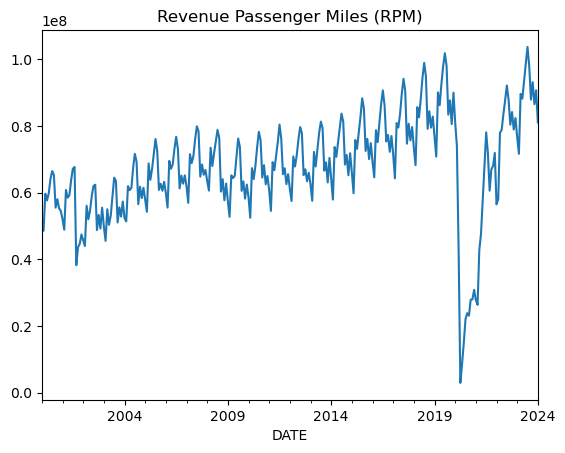

In [81]:
rpm['RPM'].plot(title="Revenue Passenger Miles (RPM)");

C:\Users\deram\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


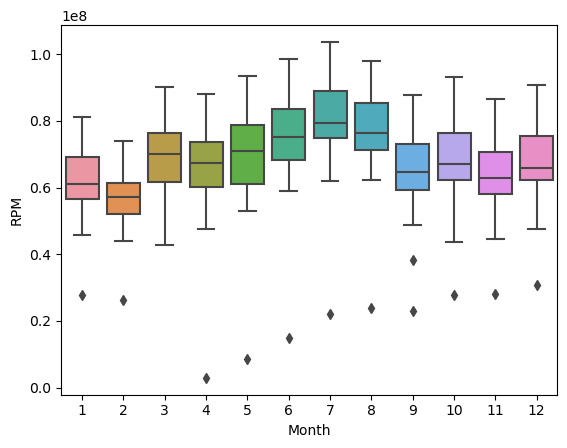

In [82]:
import seaborn
seaborn.boxplot(data=rpm, x='Month', y='RPM');

Developing a model with XGBRegressor, using `year` and `month` as predictor variables. `Revenue` is the response.<br>
The example does not use a train-test split because it is important to capture the pandemic plummet, and to exclude this from the train set would be to ignore the importance of the most recent observations. The pandemic would almost certain cause this model to appear to perform poorly if not included in the train split.

## The XGBoost Regression Model

In [84]:
import xgboost as xgb

In [90]:
regMod = xgb.XGBRegressor(booster='dart',
                          n_estimators=500,
                          eta=0.01, #learning rate; default=0.3
                          reg_lambda=1,
                          #early_stopping_rounds=50,
                          objective='reg:squarederror',
                          eval_metric=["rmse"],
                          enable_categorical=True, 
                          max_cat_to_onehot=1
                         )
FEATURES=['Year', 'Month']
TARGET=['RPM']

fit1 = regMod.fit(rpm[FEATURES], rpm[TARGET],
                  #eval_set=[(rpm[FEATURES], rpm[TARGET]), 
                  #(rpm[FEATURES], rpm[TARGET])],
                  verbose=0)

A measure of importance for the predictor variables in the XGBoost regression model `regMod`:

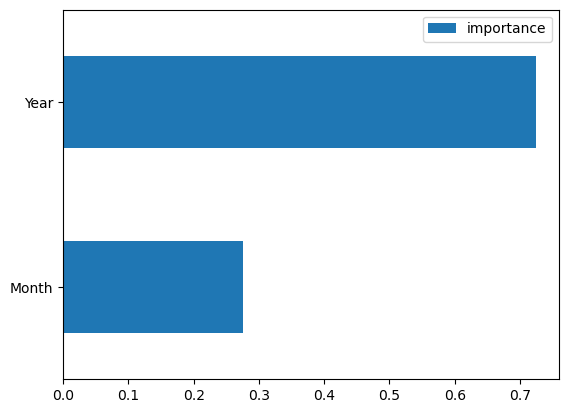

In [88]:
feat_importance = pd.DataFrame(index=regMod.feature_names_in_,
                               data=regMod.feature_importances_,
                               columns=['importance'])
feat_importance.sort_values('importance').plot(kind="barh");

In [122]:
regMod2 = xgb.XGBRegressor(booster='dart',
                           n_estimators=500,
                           eta=0.01, #learning rate; default=0.3
                           reg_lambda=1,
                           max_depth=6, #xgb default
                           #early_stopping_rounds=50,
                           objective='reg:squarederror',
                           eval_metric=["rmse"],
                           enable_categorical=True,
                           max_cat_to_onehot=1
                          )

FEATURES=['Year', 'Month', 'Months_to_Present']
TARGET=['RPM']

fit2 = regMod2.fit(rpm[FEATURES], rpm[TARGET],
                   verbose=0)

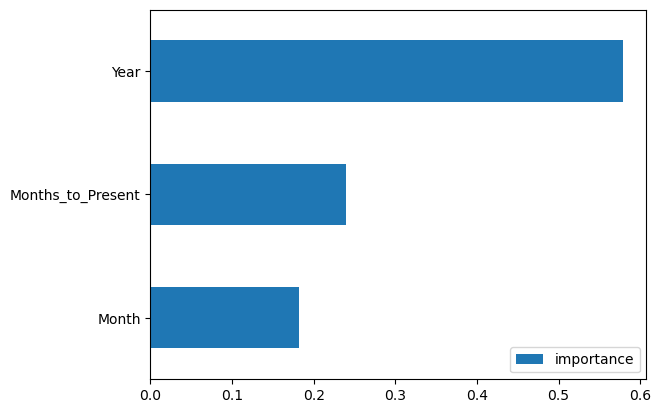

In [116]:
feat_importance = pd.DataFrame(index=regMod2.feature_names_in_,
                               data=regMod2.feature_importances_,
                               columns=['importance'])
feat_importance.sort_values('importance').plot(kind="barh");

In [211]:
regMod3 = xgb.XGBRegressor(booster='dart',
                           n_estimators=1000,
                           eta=0.01, #learning rate; default=0.3
                           reg_lambda=1,
                           max_depth=6, #xgb default
                           #early_stopping_rounds=50,
                           objective='reg:squarederror',
                           eval_metric=["rmse"],
                           enable_categorical=True,
                           max_cat_to_onehot=1
                          )

FEATURES=['Year', 'Month', 'Months_to_Present', 'lag_12Mo']
TARGET=['RPM']

fit3 = regMod3.fit(rpm[FEATURES], rpm[TARGET],
                   verbose=0)

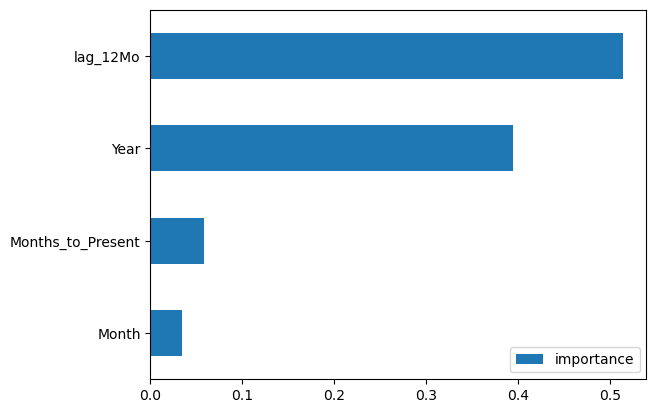

In [212]:
feat_importance = pd.DataFrame(index=regMod3.feature_names_in_,
                               data=regMod3.feature_importances_,
                               columns=['importance'])
feat_importance.sort_values('importance').plot(kind="barh");

The following code block creates the `x_test` data (datetime features for the subsequent 36 months) and uses our `reg` model to predict revenue for a 36-month horizon.

In [187]:
# 1 (dart)
x_test = pd.date_range(start='02-01-2024',
                       end='01-01-2027',
                       freq='MS')
x_test=pd.DataFrame(index=x_test)
x_test['Year']=x_test.index.year
x_test['Month']=x_test.index.month

x_test1 = x_test.copy()
preds1=fit1.predict(x_test)
x_test1['preds']=preds1

In [184]:
# 2 (dart)
x_test2 = x_test.copy()
#x_test2 = x_test2.drop('Year', axis=1)
x_test2['Months_to_Present'] = list(reversed(range(len(x_test2))))

preds2=fit2.predict(x_test2)
x_test2['preds']=preds2

In [213]:
# 3 (dart)
x_test3 = x_test.iloc[:12].copy()
#x_test3 = x_test3.drop('Year', axis=1)
x_test3['Months_to_Present'] = list(reversed(range(len(x_test3))))
x_test3['lag_12Mo'] = rpm["RPM"].iloc[-12:].values

preds3=fit3.predict(x_test3)
x_test3['preds']=preds3


x_test_a = pd.date_range(start='02-01-2025',
                        end='01-01-2026',
                        freq='MS')
x_test_a=pd.DataFrame(index=x_test_a)
x_test_a['Year']=x_test_a.index.year
x_test_a['Month']=x_test_a.index.month
x_test_a['Months_to_Present'] = list(reversed(range(len(x_test_a))))
x_test_a['lag_12Mo'] = x_test3["preds"].values

preds3a=fit3.predict(x_test_a)
x_test_a['preds']=preds3a

## Employ Time Series Cross-Validation

In [225]:
from sklearn.model_selection import TimeSeriesSplit

cv_splitter = TimeSeriesSplit(n_splits=5, test_size=24)

In [ ]:
# Future effort

## The Results

In [103]:
import matplotlib.pyplot as plt

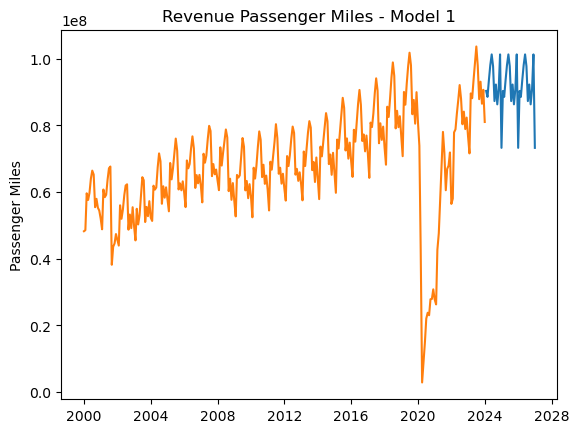

In [188]:
plt.plot(x_test1['preds'])
plt.plot(rpm['RPM'])
plt.title("Revenue Passenger Miles - Model 1")
plt.ylabel("Passenger Miles")
plt.show;

In [120]:
print(f"Penultimate 12 months: {int(x_test1[len(x_test1)-24:len(x_test1)-12:]['preds'].sum())}")
print(f"Final 12 months of forecast: {int(x_test1[len(x_test1)-12:]['preds'].sum())}")

Penultimate 12 months: 1100889344
Final 12 months of forecast: 1100889344


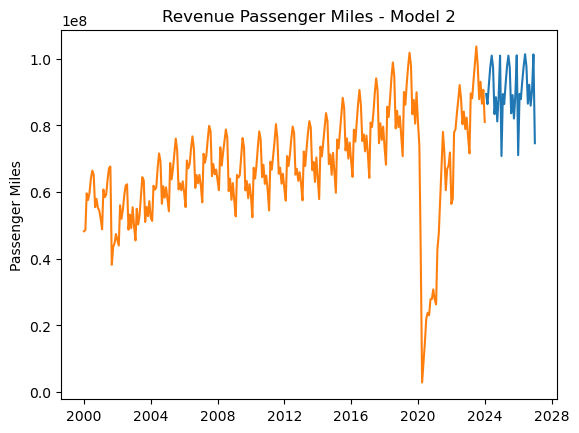

In [185]:
plt.plot(x_test2['preds'])
plt.plot(rpm['RPM'])
plt.title("Revenue Passenger Miles - Model 2")
plt.ylabel("Passenger Miles")
plt.show;

In [172]:
print(f"Penultimate 12 months: {int(x_test2[len(x_test2)-24:len(x_test2)-12:]['preds'].sum())}")
print(f"Final 12 months of forecast: {int(x_test2[len(x_test2)-12:]['preds'].sum())}")

Penultimate 12 months: 1080096640
Final 12 months of forecast: 1098472960


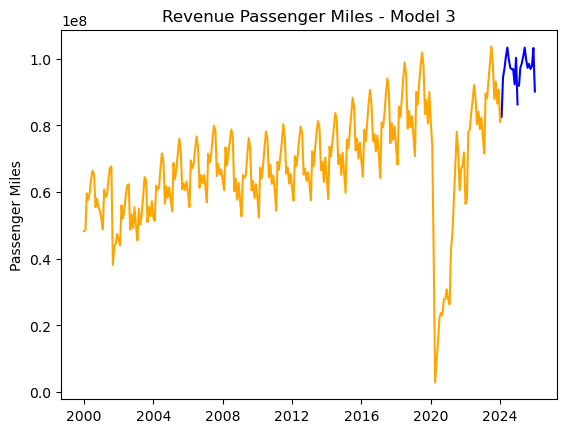

In [214]:
plt.plot(x_test_a['preds'], color='blue')
plt.plot(x_test3['preds'], color='blue')
plt.plot(rpm['RPM'], color='orange')
plt.title("Revenue Passenger Miles - Model 3")
plt.ylabel("Passenger Miles")
plt.show;

In [224]:
print(f"Penultimate 12 months: {x_test3['preds'].sum()}")
print(f"Final 12 months of forecast: {x_test_a['preds'].sum()}")

Penultimate 12 months: 1147670656.0
Final 12 months of forecast: 1175333376.0
